In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity

The Marcenko-Pastur distribution is a theoretical model describing the distribution of eigenvalues for a large random covariance matrix.
In this case, we consider a random normal dataset with 10000 samples and 1000 features (x), leading to a ratio q = T/N = 10. The MP distribution is parameterized by this ratio q and variance var = 1 in the code.
The MP PDF is plotted in blue, and its shape depends on the range defined by eMin and eMax, which represent the boundaries of the eigenvalue spectrum. The boundaries are influenced by the variance and the dimensionality ratio q.
The MP PDF exhibits a clear and well-defined shape with a peak at a certain range of eigenvalues, indicating where most of the eigenvalues are expected to lie for a random matrix of the given dimensions.

KDE:
The empirical KDE is derived from the eigenvalues obtained from the Principal Component Analysis (PCA) of the correlation matrix (eVal0). Essentially, this KDE is an estimate of the density of these eigenvalues.
The empirical KDE, plotted in red, is computed using kernel density estimation with a Gaussian kernel and a bandwidth of 0.01.
The KDE provides an empirical representation of the distribution of eigenvalues observed from the actual data, allowing us to compare this with the theoretical MP PDF.
In the plot, if the empirical KDE closely follows the shape of the MP PDF, it suggests that the data behaves similarly to a random matrix, with no strong correlations or latent factors.
Deviations between the two curves can indicate the presence of meaningful structure or correlations in the data. For instance, peaks in the empirical KDE that extend beyond the bounds of the MP PDF or different shapes may point towards significant factors that the random matrix model does not capture.
In this specific example, the empirical KDE may deviate slightly from the MP PDF, especially around the edges (eMin and eMax). Such deviations suggest that the correlation matrix of the data has some structure beyond pure randomness.

Summary:

The Marcenko-Pastur PDF provides a benchmark for evaluating whether the eigenvalues of a correlation matrix behave as if the data is purely random.
The empirical KDE allows us to visually assess if the data shows significant structure or correlations that deviate from this benchmark.
If the KDE diverges from the MP PDF, it indicates that the data might contain underlying structure or relationships worth exploring further.

In [107]:
def mpPDF(var, q, pts):
    # Marcenko-Pastur pdf
    # q = T/N

    eMin, eMax = var * (1-(1./q)**.5)**2, var*(1+(1./q)**.5) ** 2

    eVal = np.linspace(eMin, eMax, pts)

    pdf = q/(2*np.pi*var*eVal) * ((eMax-eVal)*(eVal-eMin))**.5

    pdf = pd.Series(pdf, index=eVal)

    return pdf, eMin, eMax

def getPCA(matrix):
    # Get eVal, eVec from a Hermitian matrix
    eVal, eVec = np.linalg.eigh(matrix)
    indices = eVal.argsort()[::-1] #arguments for sorting eVal desc
    eVal, eVec = eVal[indices], eVec[:,indices]
    eVal = np.diagflat(eVal)
    return eVal, eVec

def fitKDE(obs, bWidth=.25, kernel='gaussian', x=None):
    # Fit kernel to a series of obs, and deriver the probs of obs
    # x is the array of values on which the fit KDE will be evaluated
    if len(obs.shape) == 1:
        obs = obs.reshape(-1, 1)
    kde = KernelDensity(kernel=kernel, bandwidth=bWidth).fit(obs)
    if x is None:
        x=np.unique(obs).reshape(-1,1)
    if len(x.shape) == 1:
        x = x.reshape(-1,1)
    logProb = kde.score_samples(x) #log(density)
    pdf = pd.Series(np.exp(logProb), index=x.flatten())
    return pdf




In [108]:
x = np.random.normal(size=(10000, 1000))
eVal0, eVec0 = getPCA(np.corrcoef(x, rowvar=0))
pdf_mp, eMin, eMax = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=1000)
pdf_kde = fitKDE(np.diag(eVal0), bWidth=.01)


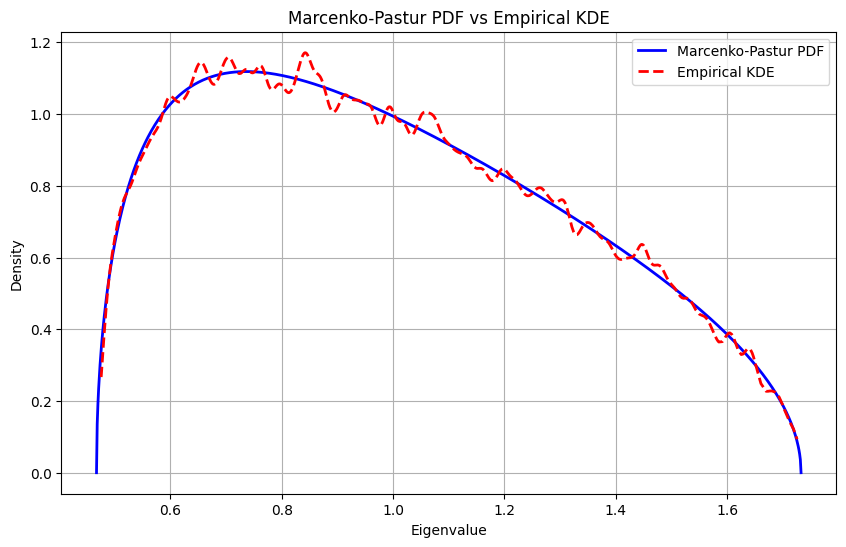

In [109]:
import matplotlib.pyplot as plt
# Plot both PDFs in a single figure
plt.figure(figsize=(10, 6))
plt.plot(pdf_mp.index, pdf_mp, label='Marcenko-Pastur PDF', color='blue', lw=2)
plt.plot(pdf_kde.index, pdf_kde, label='Empirical KDE', color='red', lw=2, linestyle='--')
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.title('Marcenko-Pastur PDF vs Empirical KDE')
plt.legend()
plt.grid(True)
plt.show()

In [110]:
def getRndCov(nCols, nFacts):
    w = np.random.normal(size=(nCols, nFacts))
    cov = np.dot(w, w.T) #random cov matrix, however not full rank
    cov+=np.diag(np.random.uniform(size=nCols)) #full rank
    return cov

def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr=cov/np.outer(std, std)
    corr[corr<-1], corr[corr>1] = -1, 1 #numerical error
    return corr



In [111]:
alpha, nCols, nFact, q = .995, 1000, 100, 10
cov = np.cov(np.random.normal(size=(nCols*q, nCols)), rowvar=0)
# combine random noise cov matrix and a low-rank matrix to simulate a system with both boise and some
# underlying structure
cov = alpha*cov + (1-alpha)*getRndCov(nCols, nFact) # noise + signal

corr0 = cov2corr(cov)

eVal0, eVec0 = getPCA(corr0)


In [112]:
pdf_mp, eMin, eMax = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=1000)
pdf_kde = fitKDE(np.diag(eVal0), bWidth=.01)

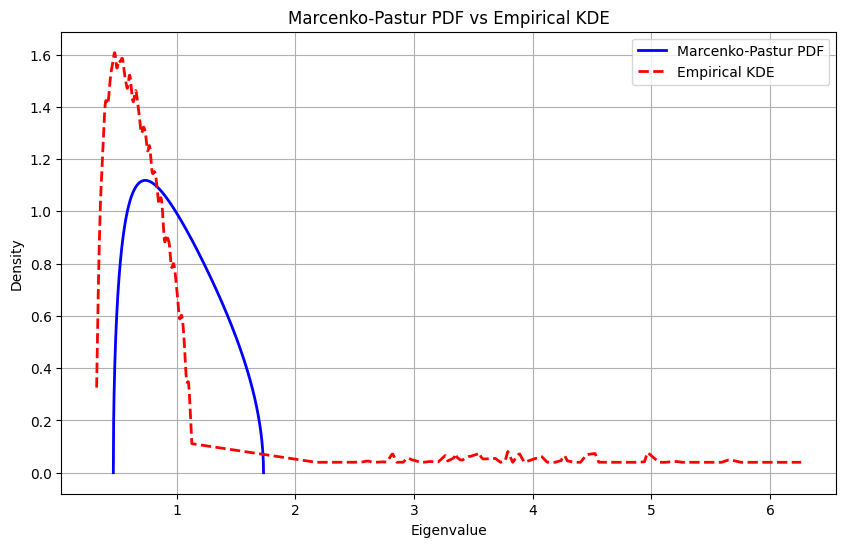

In [113]:
plt.figure(figsize=(10, 6))
plt.plot(pdf_mp.index, pdf_mp, label='Marcenko-Pastur PDF', color='blue', lw=2)
plt.plot(pdf_kde.index, pdf_kde, label='Empirical KDE', color='red', lw=2, linestyle='--')
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.title('Marcenko-Pastur PDF vs Empirical KDE')
plt.legend()
plt.grid(True)
plt.show()

In [114]:
from scipy.optimize import minimize
def errPDFs(var, eVal, q, bWidth, pts=1000):
    #Fit Error

    pdf0, _, _ = mpPDF(var[0], q, pts) #theoretical pdf

    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values) #empirical pdf
    sse = np.sum((pdf1-pdf0)**2)

    return sse

def findMaxEval(eVal, q, bWidth):
    #Findd max random eVal by fitting Marcenko's dist

    out = minimize(lambda *x:errPDFs(*x), .5, args=(eVal, q, bWidth), bounds=((1E-5, 1-1E-5),))

    if out['success']:
        var = out['x'][0]
    else:
        var =1
    eMax = var*(1+(1./q)**.5)**2
    return eMax, var

In [122]:
# lambad_+ is reported as eMax0, the value of sigma_2 (variance) is stored as var0
# the number of factors is recovered as nFacts0
eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth=.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)
print(f'cutoff level lambad_+ is: {eMax0:.02f}')
print(f'The fitted distribution variance is: {var0:.02f}')
print(f'Only {(1-var0)*100:0.2f}% of the variance can be attributed to signal')
print(f'Number of recovered factors: {nFacts0}')

cutoff level lambad_+ is: 1.17
The fitted distribution variance is: 0.68
Only 32.21% of the variance can be attributed to signal
Number of recovered factors: 100


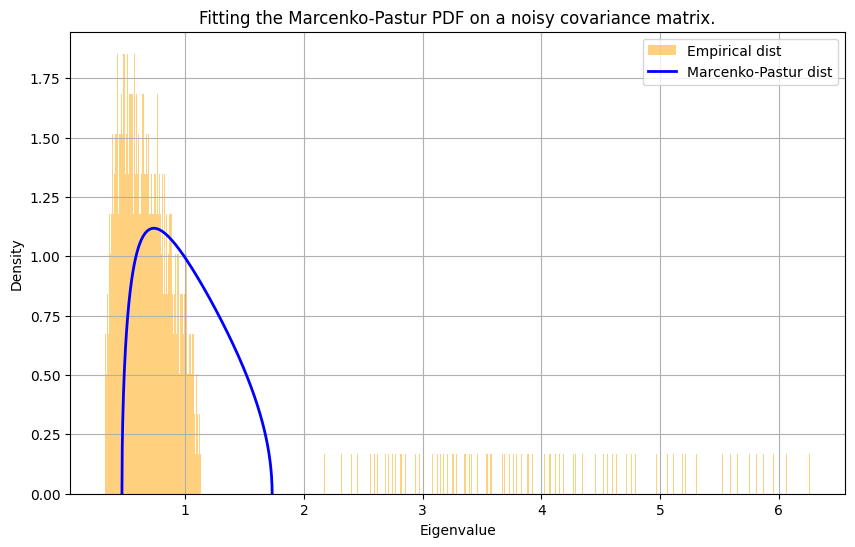

In [116]:
plt.figure(figsize=(10, 6))
plt.hist(np.diag(eVal0), bins=1000, density=True, alpha=0.5, color='orange', label='Empirical dist')
plt.plot(pdf_mp.index, pdf_mp, label='Marcenko-Pastur dist', color='blue', lw=2)
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.legend()
plt.title('Fitting the Marcenko-Pastur PDF on a noisy covariance matrix.')
plt.grid(True)
plt.show()


This type of comparison is commonly used to check if a covariance matrix primarily consists of noise of if it contains significant signals that deviate from random matrix theory predictions.

If the empirical distribution closely mathces the Marcenko-Pastur PDF, it suggests that the covariance matrix largely consists of noise.

Deviations from the Marcenko-Pastur curve (e.g. extra mass beyond the expected eigenvalue bounds) can indicate the presence of significant factors or structures that deviates from pure randomness.